# Lab 5: Regression Discontinuity Design

**Meyersson, E. (2014).** *Islamic Rule and the Empowerment of the Poor and Pious.* Econometrica, 82(1), 229-269.

This lab applies the regression discontinuity design (RDD) to study whether Islamic political rule affects women's educational attainment in Turkey. The 1994 Turkish local elections provide a natural experiment: in municipalities where an Islamic party barely won versus barely lost, treatment assignment is quasi-random.

- **Running variable**: `margin` (Islamic party's vote margin of victory)
- **Cutoff**: 0 (positive = Islamic party won)
- **Outcome**: `school_women` (share of women completing secondary school)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### Question 1: Data Exploration

In [2]:
islamic = pd.read_csv('../data/lab5/rdd_data.csv')

print(f'Shape: {islamic.shape}')
print(f'\nschool_women range: {islamic["school_women"].min():.4f} - {islamic["school_women"].max():.4f}')
print(f'margin range: {islamic["margin"].min():.4f} - {islamic["margin"].max():.4f}')
islamic.describe()

Shape: (3204, 6)

school_women range: 0.0000 - 0.6804
margin range: -1.0000 - 0.9905


,margin,school_men,school_women,log_pop,sex_ratio,log_area
count,2660.000000,3171.000000,3169.000000,2664.000000,3201.000000,3181.000000
mean,-0.278580,0.187547,0.154314,7.865344,1.072923,11.263368
std,0.222068,0.079215,0.096548,1.217750,0.243952,1.055739
min,-1.000000,0.000000,0.000000,5.493062,0.696767,7.283448
25%,-0.459990,0.131102,0.074442,7.104144,0.985185,10.582561
50%,-0.310151,0.181425,0.145455,7.484650,1.032965,10.980144
75%,-0.106111,0.235669,0.221870,8.214397,1.101167,11.636002
max,0.990510,0.683069,0.680377,15.338479,10.336364,16.186214


### Question 2: Create Treatment Variable

Define treatment as whether the Islamic party won the election (margin > 0).

In [3]:
islamic['islamic_win'] = (islamic['margin'] > 0).astype(int)

print(f'Municipalities where Islamic party won: {islamic["islamic_win"].sum()}')
print(f'Municipalities where Islamic party lost: {(1 - islamic["islamic_win"]).sum()}')

Municipalities where Islamic party won: 328
Municipalities where Islamic party lost: 2876


### Question 3: Naive Difference in Means

Compare average outcomes across all municipalities where the Islamic party won vs. lost. This is *not* a credible causal estimate because municipalities with large winning margins differ systematically from those with large losing margins.

In [4]:
diff = (islamic.loc[islamic['islamic_win'] == 1, 'school_women'].mean() -
        islamic.loc[islamic['islamic_win'] == 0, 'school_women'].mean())

print(f'Naive difference in means: {diff:.6f}')

Naive difference in means: -0.015480


### Question 4: Bandwidth Selection

The bandwidth determines the window around the cutoff within which we estimate the treatment effect. Narrower bandwidths reduce bias (observations closer to the cutoff are more comparable) but increase variance (fewer observations). We use a bandwidth of 0.239.

### Question 5: Subset to Bandwidth

In [5]:
bw = 0.239
islamic_rdd = islamic[(islamic['margin'] > -bw) & (islamic['margin'] < bw)].copy()

print(f'Observations within bandwidth: {len(islamic_rdd)}')
print(f'  Treated: {islamic_rdd["islamic_win"].sum()}')
print(f'  Control: {(1 - islamic_rdd["islamic_win"]).sum()}')

Observations within bandwidth: 1041
  Treated: 305
  Control: 736


### Question 6: RDD Estimation

Estimate the local average treatment effect at the threshold using a linear regression that controls for the running variable:

$$Y_i = \beta_0 + \beta_1 \cdot \text{margin}_i + \tau \cdot \text{islamic\_win}_i + \varepsilon_i$$

The coefficient $\hat{\tau}$ is the RDD estimate of the causal effect at the cutoff.

In [6]:
rdd_model = smf.ols('school_women ~ margin + islamic_win', data=islamic_rdd).fit()
print(rdd_model.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1277      0.006     20.045      0.000       0.115       0.140
margin         -0.2315      0.045     -5.172      0.000      -0.319      -0.144
islamic_win     0.0347      0.011      3.140      0.002       0.013       0.056


### Question 7: RDD Visualization

Plot the relationship between the running variable and the outcome with separate regression lines on each side of the cutoff.

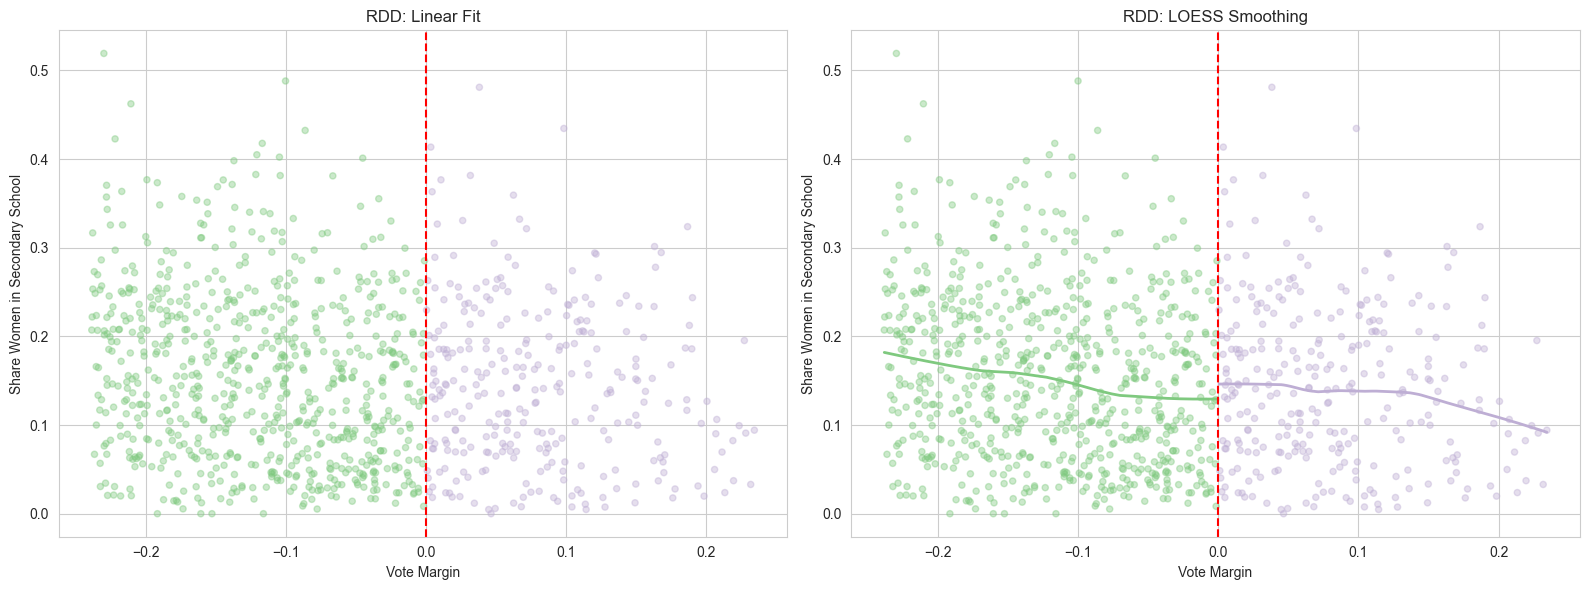

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Linear fit
ax = axes[0]
colors = islamic_rdd['islamic_win'].map({0: '#7fc97f', 1: '#beaed4'})
ax.scatter(islamic_rdd['margin'], islamic_rdd['school_women'], c=colors, alpha=0.4, s=20)

# Separate regression lines
for win, color in [(0, '#7fc97f'), (1, '#beaed4')]:
    subset = islamic_rdd[islamic_rdd['islamic_win'] == win]
    z = np.polyfit(subset['margin'], subset['school_women'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(subset['margin'].min(), subset['margin'].max(), 100)
    ax.plot(x_range, p(x_range), color=color, linewidth=2)

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.set_xlabel('Vote Margin')
ax.set_ylabel('Share Women in Secondary School')
ax.set_title('RDD: Linear Fit')

# Plot 2: LOESS smoothing
ax = axes[1]
ax.scatter(islamic_rdd['margin'], islamic_rdd['school_women'], c=colors, alpha=0.4, s=20)

for win, color in [(0, '#7fc97f'), (1, '#beaed4')]:
    subset = islamic_rdd[islamic_rdd['islamic_win'] == win].sort_values('margin')
    from statsmodels.nonparametric.smoothers_lowess import lowess
    smoothed = lowess(subset['school_women'], subset['margin'], frac=0.6)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color=color, linewidth=2)

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.set_xlabel('Vote Margin')
ax.set_ylabel('Share Women in Secondary School')
ax.set_title('RDD: LOESS Smoothing')

plt.tight_layout()
plt.show()

The discontinuity at the cutoff is visible in both the linear and LOESS plots. Municipalities where the Islamic party barely won show higher female secondary school completion rates compared to municipalities where they barely lost, consistent with Meyersson's finding that Islamic governance increased women's educational attainment.